# Comparison of base GRNs between timepoints

- Last updated: 10/24/2023
- Author: Yang-Joon Kim

- Background: We're acquiring single-cell multiome datasets during the early zebrafish development (0 budstage, 5, 10, 15, 20, and 30 somites stages, total of 6 timepoints).

- Background 2: Compared to the CisBP (promoter database)-derived base GRN + Zebrahub (scRNA-seq) GRNs, our new datasets can potentially reveal some distal regulatory elements, as well as transiently active distal enhancers (via time-resolved scATAC-seq).

- Goal: Here, we will compare the base GRNs (especially the distal regulatory elements for each gene) between timepoints.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


import os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm

In [2]:
from celloracle import motif_analysis as ma
import celloracle as co
co.__version__

/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str

'0.14.0'

In [87]:
# %config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib as mpl

plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams["savefig.dpi"] = 600
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# suppress warning messages regarding the pdf saving
import logging
logging.getLogger('fontTools').setLevel(logging.ERROR)

## Notes

- 1) We normally process the peaks and CCAN files (from cicero) to map the peaks to TSS, and then filter for the peaks that are highly co-accessible to TSS peaks . This is done in .../02_GRN/01_scATAC-seq_data_processing/02_preprocess_peak_data.ipynb notebook.

- 2) Here, we will just grab the output file (03_data_id_processed_peak_file_danRer11.csv), which has the format of two columns: peaks | mapped genes).

- 3) then, we will compare these across different timepoints, to filter the peaks that are unique in one timepoint, etc.

# Step 1. Import the mapped_TSS/genes dataframes (at different timepoints)

In [45]:
# import the TSS-mapped (linked) peaks
mapped_peaks_15somites = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/03_TDR118_processed_peak_file_danRer11.csv", index_col=0)
mapped_peaks_15somites_rep2 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/03_TDR119_processed_peak_file_danRer11.csv", index_col=0)

mapped_peaks_20somites = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR125_cicero_output/03_TDR125_processed_peak_file_danRer11.csv", index_col=0)

mapped_peaks_30somites = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR124_cicero_output/03_TDR124_processed_peak_file_danRer11.csv", index_col=0)


In [46]:
print("the number of cis-regulatory elements in 15 somites:", len(mapped_peaks_15somites))
print("the number of cis-regulatory elements in 15 somites (rep2):", len(mapped_peaks_15somites_rep2))
print("the number of cis-regulatory elements in 20 somites:", len(mapped_peaks_20somites))
print("the number of cis-regulatory elements in 30 somites:", len(mapped_peaks_30somites))

the number of cis-regulatory elements in 15 somites: 14511
the number of cis-regulatory elements in 15 somites (rep2): 14478
the number of cis-regulatory elements in 20 somites: 14205
the number of cis-regulatory elements in 30 somites: 13370


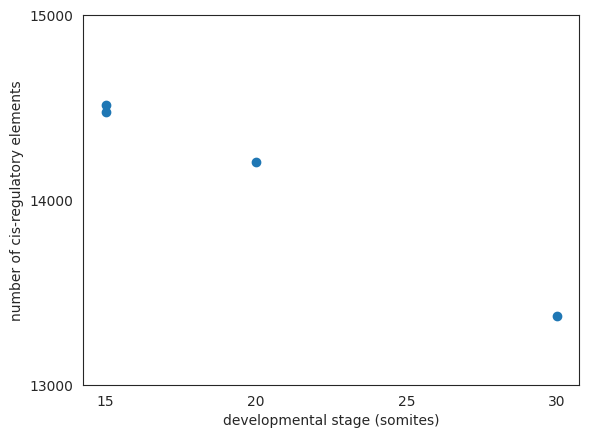

In [57]:
%matplotlib inline
plt.scatter(x=[15, 15, 20, 30], 
            y=[len(mapped_peaks_15somites), len(mapped_peaks_15somites_rep2),
               len(mapped_peaks_20somites), len(mapped_peaks_30somites)])

# Add titles and labels
plt.title('')
plt.xlabel('developmental stage (somites)')
plt.ylabel('number of cis-regulatory elements')
plt.xticks([15, 20, 25, 30])
plt.yticks([13000, 14000, 15000])
plt.ylim([13000, 15000])

plt.show()

## Note:

- There's a trend that the number of active cis-regulatory elements decreasing as the development progresses.
- At the gene level, there are genes whose cis-regulatory elements increases or decreases. We will take a closer look at this in the following sections.

# Step 2. EDA on the dataframes

- **1)** number of cis-regulatory elements at each timepoint (if we have more than two timepoints, we can assess the temporal dependence.)

- **2)** Overlapping peaks between the two timepoints (venn-diagram?): unique peaks from the peaks1 and peaks2, respetively.

    - 2-1) A pairwise comparison between the CCANs (15 vs 30, 15 vs 20, 15 vs 15 (replicates), 20 vs 30)
    

- **[Advanced]** which peaks were detected in which cell-types? This will require us to link back to the Seurat/Signac object.

- **[Advanced]** Among selected peaks (like above), what are the TF motifs that are mapped to those peaks? Do we see any interesting regulatory relationships from those (time-dependent)?

In [14]:
mapped_peaks_15somites.sort_values("gene_short_name")

,peak_id,gene_short_name
11423,chr5_33214660_33215440,LOC100001344
494,chr11_1088095_1088998,LOC100003140
8431,chr24_27423307_27424172,LOC100141479
3566,chr16_47202794_47203566,LOC100148066
6374,chr20_35247236_35247974,LOC100150082
...,...,...
6849,chr21_23046093_23046882,zw10
9952,chr3_21024761_21025654,zwi
4299,chr18_19455734_19456615,zwilch
6055,chr20_16173312_16174155,zyg11


In [15]:
mapped_peaks_30somites.sort_values("gene_short_name")

,peak_id,gene_short_name
10533,chr5_33214703_33215549,LOC100001344
455,chr11_1088072_1088906,LOC100003140
3238,chr16_47203407_47204218,LOC100148066
5875,chr20_35247224_35247983,LOC100150082
5873,chr20_35245693_35246548,LOC100150082
...,...,...
6328,chr21_23046107_23046904,zw10
9195,chr3_21024514_21025579,zwi
3933,chr18_19455698_19456596,zwilch
5579,chr20_16173304_16174146,zyg11


In [7]:
mapped_peaks_15somites.value_counts("gene_short_name")

gene_short_name
myf5         10
mir196a-1     8
her1          8
tbx16         7
hoxb3a        7
             ..
hspb11        1
hspb15        1
hspb6         1
hspb7         1
zyx           1
Length: 12674, dtype: int64

## 15 somites vs 30 somites - Check some example genes:

- her1 (Segmentation gene)

In [8]:
mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name=="her1"]

,Unnamed: 0,peak_id,gene_short_name
11889,11889,chr5_68794647_68795446,her1
11890,11890,chr5_68795688_68796600,her1
11891,11891,chr5_68797055_68797729,her1
11894,11894,chr5_68797842_68798346,her1
11897,11897,chr5_68803528_68804348,her1
11900,11900,chr5_68808342_68808880,her1
11902,11902,chr5_68809020_68809760,her1
11907,11907,chr5_68887321_68888226,her1


In [9]:
mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name=="her1"]

,Unnamed: 0,peak_id,gene_short_name
10962,10962,chr5_68794672_68795431,her1


In [17]:
mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name=="tbx16"]

,peak_id,gene_short_name
13868,chr8_51528994_51529907,tbx16
13869,chr8_51533600_51534501,tbx16
13872,chr8_51748054_51748950,tbx16
13873,chr8_51753213_51754097,tbx16
13874,chr8_51768267_51769169,tbx16
13875,chr8_51771672_51772555,tbx16
13876,chr8_51773642_51774529,tbx16


In [19]:
mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name=="tbx16"]

,peak_id,gene_short_name
12786,chr8_51753204_51754037,tbx16
12787,chr8_51754460_51755203,tbx16


In [42]:
# functions to extract the coordinates and compute the overlap between the two peaks

def extract_coordinates(peak_id):
    """Extract chromosome, start and end coordinates from peak_id."""
    chrom, start, end = peak_id.split('_')
    return chrom, int(start), int(end)

def has_overlap(peak1, peak2, threshold=10):
    """Check if two peaks have overlap based on a threshold."""
    chrom1, start1, end1 = extract_coordinates(peak1)
    chrom2, start2, end2 = extract_coordinates(peak2)
    
    # Check if they're on the same chromosome
    if chrom1 != chrom2:
        return False
    
    # Check for overlap
    overlap = max(0, min(end1, end2) - max(start1, start2))
    return overlap >= threshold

In [25]:
# To speed things up, we will compare the peaks within the same chromosomes by "group.by" for each chromosome first
df1 = mapped_peaks_15somites
df2 = mapped_peaks_30somites

# Group by chromosome
groups_df1 = df1.groupby(df1['peak_id'].str.split('_').str[0])
groups_df2 = df2.groupby(df2['peak_id'].str.split('_').str[0])

unique_df1_peaks = []
unique_df2_peaks = []

# For each chromosome, compare peaks in df1 with peaks in df2
for chrom in set(groups_df1.groups.keys()).union(groups_df2.groups.keys()):
    peaks_df1 = groups_df1.get_group(chrom) if chrom in groups_df1.groups else pd.DataFrame()
    peaks_df2 = groups_df2.get_group(chrom) if chrom in groups_df2.groups else pd.DataFrame()

    for _, row1 in peaks_df1.iterrows():
        overlapping = any(has_overlap(row1['peak_id'], row2['peak_id']) for _, row2 in peaks_df2.iterrows())
        if not overlapping:
            unique_df1_peaks.append({'peak_id': row1['peak_id'], 'gene_short_name': row1['gene_short_name']})

    for _, row2 in peaks_df2.iterrows():
        overlapping = any(has_overlap(row2['peak_id'], row1['peak_id']) for _, row1 in peaks_df1.iterrows())
        if not overlapping:
            unique_df2_peaks.append({'peak_id': row2['peak_id'], 'gene_short_name': row2['gene_short_name']})

unique_df1 = pd.DataFrame(unique_df1_peaks)
unique_df2 = pd.DataFrame(unique_df2_peaks)

print("Unique peaks in df1:")
print(unique_df1)

print("\nUnique peaks in df2:")
print(unique_df2)



Unique peaks in df1:
                      peak_id gene_short_name
0     chr13_10608306_10609218           six3a
1       chr13_1088322_1088963         cnrip1b
2     chr13_11821213_11822247         mir146a
3     chr13_11874678_11875447          trim8a
4     chr13_12389522_12389922          commd8
...                       ...             ...
1722    chr17_8211457_8212287         slc18b1
1723      chr17_842358_843163           dio3a
1724    chr17_8673601_8673929          ctbp2a
1725    chr17_8693592_8694365          ctbp2a
1726    chr17_9962054_9962970            eapp

[1727 rows x 2 columns]

Unique peaks in df2:
                     peak_id gene_short_name
0      chr13_1086571_1087134            plek
1      chr13_1236222_1237126           olig3
2    chr13_14974463_14975210            noto
3    chr13_16000506_16001401         anxa11a
4    chr13_16000506_16001401           ikzf1
..                       ...             ...
586  chr17_49442950_49443681             cga
587  chr17_51122704_

In [37]:
# peaks that are unique in 15-somites stage
unique_df1.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_15somites_to_30somites.csv")
unique_df1.value_counts("gene_short_name").head(50)

gene_short_name
myf5          9
her1          7
tbx6          6
tbx16         6
mir205        6
mir196a-1     5
mir196b       4
hoxd11a       4
hoxb3a        4
her7          4
cyp26a1       4
usp54a        4
foxc1a        3
msgn1         3
hoxd12a       3
wnt9b         3
cldni         3
mir196a-2     3
cyt1l         3
fezf2         3
ncam1a        3
rargb         3
mir196d       3
pdzk1         3
hoxc3a        3
krt4          3
pou3f2a       3
sox10         2
smyd4         2
ccn6          2
samsn1b       2
wnt8-2        2
drgx          2
s100v2        2
vtnb          2
dub           2
hoxb8b        2
slc6a5        2
mir124-5      2
catip         2
mir219-1      2
zgc:113232    2
c1s           2
mir206-1      2
zgc:112964    2
mir199-3a     2
zgc:112285    2
mir196c       2
zgc:112038    2
calm3a        2
dtype: int64

In [38]:
# peaks that are unique in 30-somites stage
unique_df2.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_30somites_to_15somites.csv")
unique_df2.value_counts("gene_short_name").head(50)

gene_short_name
hbbe1.1            6
hbae3              4
hbbe3              4
klf17              4
mir144             4
mir223             4
hbae1.3            3
hmbsa              3
tbx2b              3
slc4a1a            3
slc10a4            3
aqp1a.1            2
mbnl1              2
rfesd              2
tubb1              2
fam78ab            2
atp2b3b            2
cap2               2
zgc:154142         2
hsd17b8            2
zgc:77287          2
desma              2
klc3               2
gata1a             2
klf1               2
si:dkey-211g8.6    2
nudt2              2
si:dkey-194e6.1    2
mir183             2
rnf144b            1
rnaset2            1
rhd                1
rnpepl1            1
rpz3               1
rnasel3            1
rfng               1
rhcga              1
rgs13              1
rrm2               1
rex1bd             1
rcor2              1
rcan2              1
ralbp1             1
ralbb              1
rab3db             1
rab3ab             1
qpctla            

In [39]:
# Check for some genes
gene_name = "rpz3"
print(mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name==gene_name])
print(mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name==gene_name])

Empty DataFrame
Columns: [peak_id, gene_short_name]
Index: []
                      peak_id gene_short_name
3230  chr16_46459365_46460332            rpz3


In [40]:
# Check for some genes
gene_name = "noto"
print(mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name==gene_name])
print(mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name==gene_name])

                      peak_id gene_short_name
1543  chr13_14975609_14976433            noto
                      peak_id gene_short_name
1406  chr13_14974463_14975210            noto
1407  chr13_14975703_14976519            noto


In [59]:
# Copy the dataframes for future comparisons
unique_15_30 = unique_df1
unique_30_15 = unique_df2

## 15 somites vs 20 somites

In [58]:
# To speed things up, we will compare the peaks within the same chromosomes by "group.by" for each chromosome first
df1 = mapped_peaks_15somites
df2 = mapped_peaks_20somites

# Group by chromosome
groups_df1 = df1.groupby(df1['peak_id'].str.split('_').str[0])
groups_df2 = df2.groupby(df2['peak_id'].str.split('_').str[0])

unique_df1_peaks = []
unique_df2_peaks = []

# For each chromosome, compare peaks in df1 with peaks in df2
for chrom in set(groups_df1.groups.keys()).union(groups_df2.groups.keys()):
    peaks_df1 = groups_df1.get_group(chrom) if chrom in groups_df1.groups else pd.DataFrame()
    peaks_df2 = groups_df2.get_group(chrom) if chrom in groups_df2.groups else pd.DataFrame()

    for _, row1 in peaks_df1.iterrows():
        overlapping = any(has_overlap(row1['peak_id'], row2['peak_id']) for _, row2 in peaks_df2.iterrows())
        if not overlapping:
            unique_df1_peaks.append({'peak_id': row1['peak_id'], 'gene_short_name': row1['gene_short_name']})

    for _, row2 in peaks_df2.iterrows():
        overlapping = any(has_overlap(row2['peak_id'], row1['peak_id']) for _, row1 in peaks_df1.iterrows())
        if not overlapping:
            unique_df2_peaks.append({'peak_id': row2['peak_id'], 'gene_short_name': row2['gene_short_name']})

unique_15_20 = pd.DataFrame(unique_df1_peaks)
unique_20_15 = pd.DataFrame(unique_df2_peaks)

print("Unique peaks in 15 somites (vs 20 somites):")
print(unique_15_20)

print("\nUnique peaks in 20 somites (vs 15 somites):")
print(unique_20_15)

Unique peaks in df1:
                     peak_id gene_short_name
0    chr13_10232131_10232803           six2a
1    chr13_10264436_10265221           six3a
2    chr13_10608306_10609218           six3a
3      chr13_1085665_1086443            plek
4      chr13_1088322_1088963         cnrip1b
..                       ...             ...
684  chr17_38254847_38255263          nkx2.9
685  chr17_47090342_47090722      zgc:103755
686  chr17_48946883_48947136          hs1bp3
687  chr17_49407976_49408573         mthfd1b
688    chr17_5960644_5961413        mir206-2

[689 rows x 2 columns]

Unique peaks in df2:
                     peak_id gene_short_name
0    chr13_12668056_12668731         fam241a
1    chr13_18692017_18692630           sfxn3
2    chr13_20519560_20520149          gfra1a
3    chr13_25548730_25549035           mcmbp
4    chr13_29980937_29981599          hif1an
..                       ...             ...
393  chr17_43675350_43676257           egr2a
394      chr17_449755_450376     

In [65]:
print(unique_15_20.value_counts("gene_short_name").head(20))

print(unique_20_15.value_counts("gene_short_name").head(20))

gene_short_name
myf5         7
mir196a-1    6
her1         6
hoxb3a       4
her7         4
tbx16        4
cyp26a1      4
mir196b      4
hoxc3a       3
hoxc6a       3
fezf2        3
usp54a       3
ncam1a       3
mir196a-2    3
tbx6         3
mir196d      3
msgn1        3
sox10        2
ecrg4a       2
elavl3       2
dtype: int64
gene_short_name
myog                 4
pigr                 2
hbbe3                2
cacna1sa             2
bricd5               2
stab1                2
LOC100150619         1
si:ch211-202h22.8    1
si:ch211-184m13.4    1
si:ch211-15e22.3     1
si:ch211-125e6.12    1
si:ch211-122l24.6    1
si:ch211-121a2.2     1
sfxn3                1
serpinb1l2           1
serpina10a           1
si:ch211-240l19.6    1
serac1               1
sept9b               1
selenoh              1
dtype: int64


In [63]:
unique_15_20.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_15somites_to_20somites.csv")
unique_20_15.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_20somites_to_15somites.csv")

## 20 somites vs 30 somites



In [67]:
# To speed things up, we will compare the peaks within the same chromosomes by "group.by" for each chromosome first
df1 = mapped_peaks_20somites
df2 = mapped_peaks_30somites

# Group by chromosome
groups_df1 = df1.groupby(df1['peak_id'].str.split('_').str[0])
groups_df2 = df2.groupby(df2['peak_id'].str.split('_').str[0])

unique_df1_peaks = []
unique_df2_peaks = []

# For each chromosome, compare peaks in df1 with peaks in df2
for chrom in set(groups_df1.groups.keys()).union(groups_df2.groups.keys()):
    peaks_df1 = groups_df1.get_group(chrom) if chrom in groups_df1.groups else pd.DataFrame()
    peaks_df2 = groups_df2.get_group(chrom) if chrom in groups_df2.groups else pd.DataFrame()

    for _, row1 in peaks_df1.iterrows():
        overlapping = any(has_overlap(row1['peak_id'], row2['peak_id']) for _, row2 in peaks_df2.iterrows())
        if not overlapping:
            unique_df1_peaks.append({'peak_id': row1['peak_id'], 'gene_short_name': row1['gene_short_name']})

    for _, row2 in peaks_df2.iterrows():
        overlapping = any(has_overlap(row2['peak_id'], row1['peak_id']) for _, row1 in peaks_df1.iterrows())
        if not overlapping:
            unique_df2_peaks.append({'peak_id': row2['peak_id'], 'gene_short_name': row2['gene_short_name']})

unique_20_30 = pd.DataFrame(unique_df1_peaks)
unique_30_20 = pd.DataFrame(unique_df2_peaks)

print("Unique peaks in df1:")
print(unique_20_30.value_counts("gene_short_name").head(20))

print("\nUnique peaks in df2:")
print(unique_30_20.value_counts("gene_short_name").head(20))

Unique peaks in df1:
gene_short_name
myog                 5
mir205               4
tbx6                 3
exoc3l4              2
gpr182               2
si:ch211-15e22.3     2
zgc:113232           2
mogat2               2
arhgef3l             2
si:ch211-175f11.5    2
si:ch211-188c16.1    2
s100v2               2
slc25a24l            2
slc6a17              2
zgc:172225           2
krt98                2
si:ch211-202h22.8    2
ch25hl1.1            2
ifngr1               2
krt4                 2
dtype: int64

Unique peaks in df2:
gene_short_name
hbbe1.1    6
klf17      4
mir144     4
hbae3      4
mir223     4
hbae1.3    3
slc10a4    3
hbbe3      3
hmbsa      3
tbx2b      3
nudt2      2
hes2.2     2
aqp1a.1    2
plek       2
desma      2
atp2b3b    2
tubb1      2
mbnl1      2
mfap4      2
cap2       2
dtype: int64


In [68]:
unique_20_30.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_20somites_to_30somites.csv")
unique_30_20.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_30somites_to_20somites.csv")

## 15 somites vs 15 somites (biological replicates)

- This will be our negative control for the cis-regulatory elements.
- In theory, there should be no meaningful differences between the biological replicates (CCANs)

In [69]:
# To speed things up, we will compare the peaks within the same chromosomes by "group.by" for each chromosome first
df1 = mapped_peaks_15somites
df2 = mapped_peaks_15somites_rep2

# Group by chromosome
groups_df1 = df1.groupby(df1['peak_id'].str.split('_').str[0])
groups_df2 = df2.groupby(df2['peak_id'].str.split('_').str[0])

unique_df1_peaks = []
unique_df2_peaks = []

# For each chromosome, compare peaks in df1 with peaks in df2
for chrom in set(groups_df1.groups.keys()).union(groups_df2.groups.keys()):
    peaks_df1 = groups_df1.get_group(chrom) if chrom in groups_df1.groups else pd.DataFrame()
    peaks_df2 = groups_df2.get_group(chrom) if chrom in groups_df2.groups else pd.DataFrame()

    for _, row1 in peaks_df1.iterrows():
        overlapping = any(has_overlap(row1['peak_id'], row2['peak_id']) for _, row2 in peaks_df2.iterrows())
        if not overlapping:
            unique_df1_peaks.append({'peak_id': row1['peak_id'], 'gene_short_name': row1['gene_short_name']})

    for _, row2 in peaks_df2.iterrows():
        overlapping = any(has_overlap(row2['peak_id'], row1['peak_id']) for _, row1 in peaks_df1.iterrows())
        if not overlapping:
            unique_df2_peaks.append({'peak_id': row2['peak_id'], 'gene_short_name': row2['gene_short_name']})

unique_15_15_rep1 = pd.DataFrame(unique_df1_peaks)
unique_15_15_rep2 = pd.DataFrame(unique_df2_peaks)

print("Unique peaks in df1:")
print(unique_15_15_rep1.value_counts("gene_short_name").head(20))

print("\nUnique peaks in df2:")
print(unique_15_15_rep2.value_counts("gene_short_name").head(20))

Unique peaks in df1:
gene_short_name
ripply2       2
ncam1a        2
pcdh8         2
cldni         1
myf5          1
pak2a         1
pitpnc1b      1
rargb         1
rx2           1
cnksr1        1
snai1a        1
sox21b        1
stra6         1
vax1          1
vgll4l        1
zgc:136538    1
mir219-1      1
mir196d       1
mir196a-2     1
mir124-5      1
dtype: int64

Unique peaks in df2:
gene_short_name
pou3f3a    3
coro7      1
foxc1a     1
mllt3      1
sox10      1
sox19a     1
vwde       1
dtype: int64


In [73]:
print(len(unique_15_15_rep1))
print(len(unique_15_15_rep2))

37
9


In [70]:
unique_15_15_rep1.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_15somites_to_15somites_rep1.csv")
unique_15_15_rep2.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_15somites_to_15somites_rep2.csv")

## visualization 

We want to visualize the above results in different ways.

- 1) a rank plot showing the genes (y-axis), and the number of cis-regulatory elements (x-axis): For all combinations

- 2) linkage plot showing the active regulatory elements for the top genes, at different timepoints (show the increase/decrease of cis-regulatory elements).

In [76]:
unique_15_20.value_counts("gene_short_name").head(20)

gene_short_name
myf5         7
mir196a-1    6
her1         6
hoxb3a       4
her7         4
tbx16        4
cyp26a1      4
mir196b      4
hoxc3a       3
hoxc6a       3
fezf2        3
usp54a       3
ncam1a       3
mir196a-2    3
tbx6         3
mir196d      3
msgn1        3
sox10        2
ecrg4a       2
elavl3       2
dtype: int64

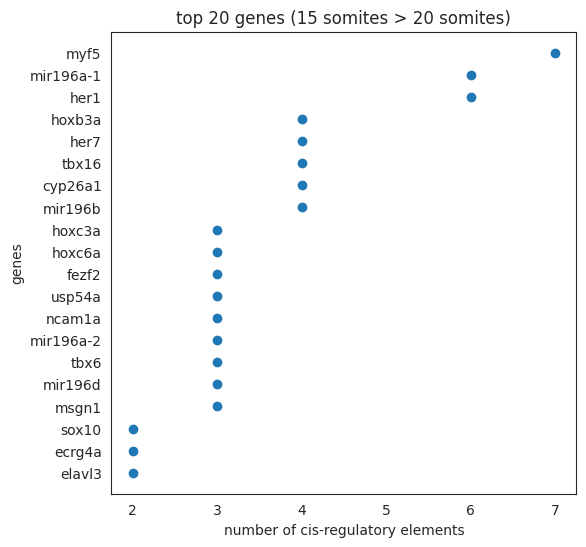

In [86]:
# 15somites > 20somites
top_genes = unique_15_20.value_counts("gene_short_name").head(20)

# Extract gene names and their counts
gene_names = top_genes.index.tolist()
counts = top_genes.values

# Create rank plot
plt.figure(figsize=(6,6))  # Adjust the figure size
plt.scatter(counts, gene_names)

# Add titles and labels
# plt.title('Top 20 Genes Rank Plot')
plt.title("top 20 genes (15 somites > 20 somites)")
plt.xlabel('number of cis-regulatory elements')
plt.ylabel('genes')
#plt.grid(axis='x')  # Add a grid on the x-axis for better readability
# Invert the y-axis order
plt.gca().invert_yaxis()

# save the figure
plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_15vs20.png")
plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_15vs20.pdf")

# Display the plot
plt.show()

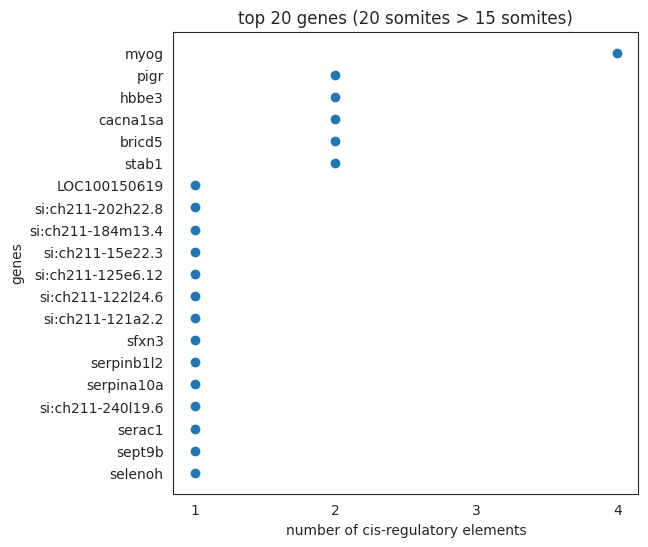

In [89]:
# 20somites > 15somites
top_genes = unique_20_15.value_counts("gene_short_name").head(20)

# Extract gene names and their counts
gene_names = top_genes.index.tolist()
counts = top_genes.values

# Create rank plot
plt.figure(figsize=(6,6))  # Adjust the figure size
plt.scatter(counts, gene_names)

# Add titles and labels
# plt.title('Top 20 Genes Rank Plot')
plt.title("top 20 genes (20 somites > 15 somites)")
plt.xlabel('number of cis-regulatory elements')
plt.xticks([1, 2, 3, 4])
plt.ylabel('genes')
#plt.grid(axis='x')  # Add a grid on the x-axis for better readability
# Invert the y-axis order
plt.gca().invert_yaxis()

# save the figure
plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_20vs15.png")
plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_20vs15.pdf")

# Display the plot
plt.show()

We can repeat this for all pairs for the comparison.

Note that we might want to make one for 15 somites stage, between two biological replicates.

# Step 3. Comparison of base GRNs

- [To-Do] Move this section (and forward) to another notebook (to keep things modular)

- Now, we want to compare the regulatory TFs for each gene (cis-regulatory element), especially for genes which have different cis-regulatory profiles over time. 

- 1) We will import the base GRN (which is a dataframe of peaks-by-TFs) for each timeframe.
- 2) Pick top 10-20 (or 50) genes whose cis-regulatory elements change significantly over time (from the Step 2.)
- 3) Map out the TFs that are differentially activating/repressing the genes at the base GRN level (for the top 10-50 genes)

In [92]:
# Check the peaks that were in 15 somites but not in 20 somites (or 30 somites)

unique_15_20[unique_15_20.gene_short_name=="myf5"]

,peak_id,gene_short_name
116,chr4_21640698_21641565,myf5
117,chr4_21660593_21661497,myf5
118,chr4_21696596_21697063,myf5
119,chr4_21724146_21724976,myf5
120,chr4_21738624_21739481,myf5
121,chr4_21744914_21745703,myf5
122,chr4_21745860_21746718,myf5


In [91]:
baseGRN_15somites = pd.read_parquet("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/05_TDR118_base_GRN_dataframe.parquet")
baseGRN_15somites

,peak_id,gene_short_name,A6H8I1_DANRE,CABZ01017151.1,CABZ01056727.1,CABZ01057488.2,CABZ01066696.1,CABZ01067175.1,CABZ01079847.1,CABZ01081359.1,...,znf143b,znf148,znf281a,znf281b,znf652,znf653,znf711,znf740b,znf76,zzz3
0,chr10_10310135_10311044,mir219-1,0,0,1,0,0,1,0,0,...,0,1,1,1,0,0,0,0,0,0
1,chr10_10312654_10313520,urm1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr10_10318857_10319768,mir219-1,0,0,1,1,0,1,0,0,...,0,1,1,1,0,0,0,0,0,0
3,chr10_10330150_10331040,mir219-1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr10_10728430_10729439,swi5,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14506,chr9_9670995_9671898,gsk3ba,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
14507,chr9_9841650_9842440,fstl1b,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14508,chr9_9960217_9961167,prmt2,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14509,chr9_9977190_9977958,ugt1a1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
baseGRN_15somites[baseGRN_15somites.gene_short_name=="myf5"]

,peak_id,gene_short_name,A6H8I1_DANRE,CABZ01017151.1,CABZ01056727.1,CABZ01057488.2,CABZ01066696.1,CABZ01067175.1,CABZ01079847.1,CABZ01081359.1,...,znf143b,znf148,znf281a,znf281b,znf652,znf653,znf711,znf740b,znf76,zzz3
10758,chr4_21640698_21641565,myf5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10761,chr4_21660593_21661497,myf5,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10762,chr4_21694264_21695059,myf5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10763,chr4_21696596_21697063,myf5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10764,chr4_21724146_21724976,myf5,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10765,chr4_21736676_21737587,myf5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10766,chr4_21738624_21739481,myf5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10767,chr4_21740822_21741654,myf5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10768,chr4_21744914_21745703,myf5,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10769,chr4_21745860_21746718,myf5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
unique_15_20[unique_15_20.gene_short_name=="myf5"]

,peak_id,gene_short_name
116,chr4_21640698_21641565,myf5
117,chr4_21660593_21661497,myf5
118,chr4_21696596_21697063,myf5
119,chr4_21724146_21724976,myf5
120,chr4_21738624_21739481,myf5
121,chr4_21744914_21745703,myf5
122,chr4_21745860_21746718,myf5


In [106]:
filtered_df

,peak_id,A6H8I1_DANRE,CABZ01017151.1,CABZ01056727.1,CABZ01057488.2,CABZ01066696.1,CABZ01067175.1,CABZ01079847.1,CABZ01081359.1,CABZ01102124.1,...,znf143b,znf148,znf281a,znf281b,znf652,znf653,znf711,znf740b,znf76,zzz3
10758,chr4_21640698_21641565,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10761,chr4_21660593_21661497,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
10762,chr4_21694264_21695059,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10763,chr4_21696596_21697063,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10764,chr4_21724146_21724976,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10765,chr4_21736676_21737587,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10766,chr4_21738624_21739481,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10767,chr4_21740822_21741654,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10768,chr4_21744914_21745703,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10769,chr4_21745860_21746718,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
# define a dict to save the peaks-regulatory TFs as pairs
genes_for_peak = {}

# Filter dataframe for peaks with gene_short_name as 'myf5'
filtered_df = baseGRN_15somites[baseGRN_15somites['gene_short_name'] == 'myf5']

# Drop the 'gene_short_name' column as it's no longer needed for the extraction
filtered_df = filtered_df.drop(columns=['gene_short_name'])

# Extract genes with "1" for each peak
genes_for_peak = {}
for peak, row in filtered_df.iterrows():
    genes_for_peak[row.peak_id] = row.index[row == 1].tolist()

print(genes_for_peak)

# for peak in unique_15_20[unique_15_20.gene_short_name=="myf5"].peak_id:
#     baseGRN_15somites[baseGRN_15somites.peak_id==peak]

{'chr4_21640698_21641565': ['CABZ01066696.1', 'E2F1', 'E2F2', 'FQ311895.1', 'FQ377628.1', 'alx1', 'alx3', 'alx4a', 'alx4b', 'arxa', 'arxb', 'ascl1a', 'atoh1a', 'atoh1b', 'barhl1a', 'barhl1b', 'barhl2', 'barx1', 'barx2', 'batf', 'batf3', 'bhlha15', 'bhlhe22', 'bhlhe23', 'bsx', 'creb3l1', 'creb3l2', 'ctcf', 'dlx1a', 'dlx2a', 'dlx2b', 'dlx3b', 'dlx4a', 'dlx4b', 'dlx5a', 'dlx6a', 'dmrt1', 'dmrt2a', 'dmrt2b', 'dmrt3a', 'dmrta2', 'drgx', 'e2f3', 'e2f4', 'e2f5', 'e2f7', 'e2f8', 'emx1', 'emx2', 'emx3', 'en1a', 'en1b', 'en2a', 'en2b', 'eve1', 'evx1', 'evx2', 'ferd3l', 'fosaa', 'fosab', 'fosb', 'fosl1a', 'fosl2', 'gata1a', 'gata1b', 'gata2a', 'gata2b', 'gata3', 'gata4', 'gata5', 'gata6', 'gbx1', 'gbx2', 'gsx1', 'gsx2', 'hmbox1a', 'hmbox1b', 'hnf1a', 'hnf1ba', 'hnf1bb', 'hoxa10b', 'hoxa11a', 'hoxa11b', 'hoxa13a', 'hoxa13b', 'hoxa2b', 'hoxa4a', 'hoxb10a', 'hoxb13a', 'hoxb2a', 'hoxb3a', 'hoxc10a', 'hoxc11a', 'hoxc11b', 'hoxc12a', 'hoxc12b', 'hoxc13a', 'hoxc13b', 'hoxd10a', 'hoxd11a', 'hoxd12a', 'ho

In [129]:
for peak in genes_for_peak.keys():
    print(peak)
    print(len(genes_for_peak[str(peak)]))

chr4_21640698_21641565
267
chr4_21660593_21661497
352
chr4_21694264_21695059
129
chr4_21696596_21697063
105
chr4_21724146_21724976
311
chr4_21736676_21737587
307
chr4_21738624_21739481
238
chr4_21740822_21741654
366
chr4_21744914_21745703
333
chr4_21745860_21746718
195


In [146]:
unique_15_20_peaks = unique_15_20[unique_15_20.gene_short_name=="myf5"].peak_id.to_list()
unique_15_20_peaks

shared_peaks = [peak for peak in genes_for_peak.keys() if peak not in unique_15_20_peaks]
shared_peaks

unique_15_20_regTFs = set(gene for peak_id in unique_15_20_peaks for gene in genes_for_peak[peak_id])

shared_regTFs = set(gene for peak_id in shared_peaks for gene in genes_for_peak[peak_id])


In [149]:
# the number of unique and shared regulatory TFs between 15 somites and 20 somites (unique in 15 compared to 20 somites)
print(len(unique_15_20_regTFs))
print(len(shared_regTFs))

625
471


## Notes

- For the base GRN, there are too many TFs that "might" bind to the regulatory elements. (as the base GRN is merely for constructing basis for regularized linear regression for each cell-type).

- So, we will take a look at the cell-type specific GRNs at earlier and later timepoints, to see which TFs appear at specific timepoints.

- Note that the cell-type specific GRN is a combination of scATAC-seq (base GRN) and scRNA-seq (gene expression for linear regression for the edge width), we won't be able to de-couple the base GRN effect.

- To account for this, we will use the list of regulatory TFs that are unique in one timepoint versus the other timepoint.

- test with 15 somites vs 20 somites

In [100]:
gene_name = "myog"
print(unique_15_20[unique_15_20.gene_short_name==gene_name])
print(unique_20_30[unique_20_30.gene_short_name==gene_name])
print(unique_15_30[unique_15_30.gene_short_name==gene_name])

Empty DataFrame
Columns: [peak_id, gene_short_name]
Index: []
                     peak_id gene_short_name
192  chr11_22544195_22545006            myog
193  chr11_22578597_22579479            myog
194  chr11_22605698_22606577            myog
195  chr11_22608640_22609509            myog
196  chr11_22611484_22612314            myog
                     peak_id gene_short_name
218  chr11_22578568_22579469            myog
219  chr11_22608633_22609498            myog


In [151]:
# define the gene name
gene_name = "myf5"
mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name==gene_name]

,peak_id,gene_short_name
10758,chr4_21640698_21641565,myf5
10761,chr4_21660593_21661497,myf5
10762,chr4_21694264_21695059,myf5
10763,chr4_21696596_21697063,myf5
10764,chr4_21724146_21724976,myf5
10765,chr4_21736676_21737587,myf5
10766,chr4_21738624_21739481,myf5
10767,chr4_21740822_21741654,myf5
10768,chr4_21744914_21745703,myf5
10769,chr4_21745860_21746718,myf5


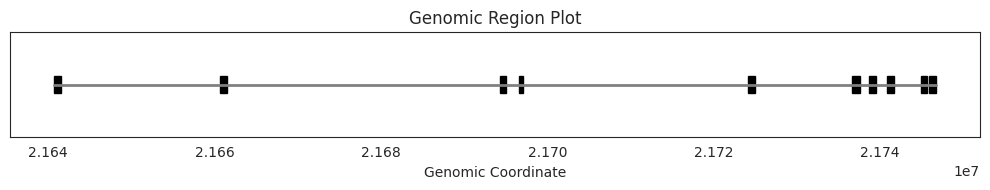

In [156]:
# visualize the genomic regions with a linear plot
import matplotlib.patches as patches

# define the gene name
gene_name = "myf5"
df = mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name==gene_name]

# Parsing peak_id to get start and end coordinates
df['start'] = df['peak_id'].str.split('_').str[1].astype(int)
df['end'] = df['peak_id'].str.split('_').str[2].astype(int)

# Plotting
fig, ax = plt.subplots(figsize=(10, 2))

# Plotting a thin line for the genomic region
ax.plot([df['start'].min(), df['end'].max()], [1, 1], color='grey', linewidth=2)

# Adjusting the height and position of the boxes
box_height = 0.1
box_position = 1 - box_height / 2

# Plotting black boxes for each peak using rectangles
for _, row in df.iterrows():
    rect = patches.Rectangle((row['start'], box_position), row['end'] - row['start'], box_height, linewidth=1, edgecolor='black', facecolor='black')
    ax.add_patch(rect)

# Setting y-axis limits and removing y-axis ticks
ax.set_ylim(0.7, 1.3)
ax.set_yticks([])
ax.set_xlabel('Genomic Coordinate')
ax.set_title('Genomic Region Plot')

plt.tight_layout()
plt.show()







In [ ]:
# visualize the genomic regions with a linear plot
import matplotlib.patches as patches

# define the gene name
gene_name = "myf5"
df = mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name==gene_name]

# Parsing peak_id to get start and end coordinates
df['start'] = df['peak_id'].str.split('_').str[1].astype(int)
df['end'] = df['peak_id'].str.split('_').str[2].astype(int)

# Plotting
fig, ax = plt.subplots(figsize=(10, 2))

# Plotting a thin line for the genomic region
ax.plot([df['start'].min(), df['end'].max()], [1, 1], color='grey', linewidth=2)

# Adjusting the height and position of the boxes
box_height = 0.1
box_position = 1 - box_height / 2

# Plotting black boxes for each peak using rectangles
for _, row in df.iterrows():
    rect = patches.Rectangle((row['start'], box_position), row['end'] - row['start'], box_height, linewidth=1, edgecolor='black', facecolor='black')
    ax.add_patch(rect)

# Setting y-axis limits and removing y-axis ticks
ax.set_ylim(0.7, 1.3)
ax.set_yticks([])
ax.set_xlabel('Genomic Coordinate')
ax.set_title('Genomic Region Plot')

plt.tight_layout()
plt.show()

In [162]:
# a function to plot the genomic regions
import matplotlib.patches as patches

# def plot_peaks(df, ax, color):
#     """Function to plot peaks from a dataframe."""
#     # Parsing peak_id to get start and end coordinates
#     df['start'] = df['peak_id'].str.split('_').str[1].astype(int)
#     df['end'] = df['peak_id'].str.split('_').str[2].astype(int)

#     # Adjusting the height and position of the boxes
#     box_height = 0.2
#     box_position = 1 - box_height / 2

#     # Plotting boxes for each peak using rectangles
#     for _, row in df.iterrows():
#         rect = patches.Rectangle((row['start'], box_position), row['end'] - row['start'], box_height, linewidth=1, edgecolor=color, facecolor=color)
#         ax.add_patch(rect)

def compute_start_end(df):
    """Function to compute start and end coordinates for a dataframe."""
    df['start'] = df['peak_id'].str.split('_').str[1].astype(int)
    df['end'] = df['peak_id'].str.split('_').str[2].astype(int)
    return df

def plot_peaks(df, ax, color):
    """Function to plot peaks from a dataframe."""
    for _, row in df.iterrows():
        rect = patches.Rectangle((row['start'], 0.9), row['end'] - row['start'], 0.2, linewidth=1, edgecolor=color, facecolor=color)
        ax.add_patch(rect)
        
def plot_peaks_with_y_adjustment(df, ax, color):
    """Function to plot peaks with y adjustment for overlapping peaks."""
    previous_end = 0
    y_base = 0.9
    for _, row in df.iterrows():
        if row['start'] < previous_end:
            y_base += 0.2
        else:
            y_base = 0.9
        rect = patches.Rectangle((row['start'], y_base), row['end'] - row['start'], 0.2, linewidth=1, edgecolor=color, facecolor=color)
        ax.add_patch(rect)
        previous_end = row['end']

def plot_peaks_with_alpha(df, ax, color):
    """Function to plot peaks with alpha for overlapping peaks."""
    for _, row in df.iterrows():
        rect = patches.Rectangle((row['start'], 0.9), row['end'] - row['start'], 0.2, linewidth=1, edgecolor=color, facecolor=color, alpha=0.5)
        ax.add_patch(rect)

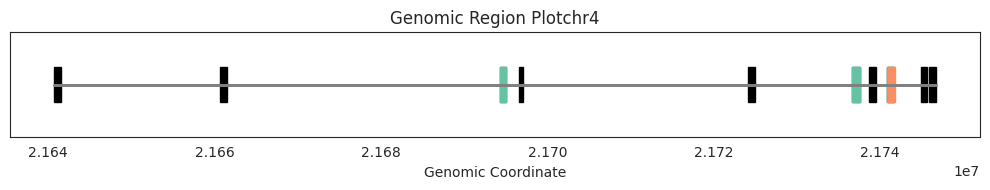

In [168]:
import seaborn as sns  # For using Seaborn's color palettes
# Setting up color options
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
seaborn_set2 = sns.color_palette("Set2")

# define the gene name
gene_name = "myf5"

# define the dataframes
# 15 somites
df1 = mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name==gene_name]
# 20 somites
df2 = mapped_peaks_20somites[mapped_peaks_20somites.gene_short_name==gene_name]
# 30 somites
df3 = mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name==gene_name]

# compute the start and end positions of the peaks
df1 = compute_start_end(df1)
df2 = compute_start_end(df2)
df3 = compute_start_end(df3)

# Extracting chromosome number
chromosome = df1['peak_id'].iloc[0].split('_')[0]

# Plotting

plot_func = plot_peaks_with_y_adjustment

fig, ax = plt.subplots(figsize=(10, 2))

# Plotting a thin line for the genomic region
genomic_start = min(df1['start'].min(), df2['start'].min(), df3['start'].min())
genomic_end = max(df1['end'].max(), df2['end'].max(), df["end"].max())
ax.plot([genomic_start, genomic_end], [1, 1], color='grey', linewidth=2)


# Plotting a thin line for the genomic region
ax.plot([df1['start'].min(), df1['end'].max()], [1, 1], color='grey', linewidth=2)

# Plot peaks from df1 in black
plot_func(df1, ax, 'black')

# Plot peaks from df2 in a different color, e.g., 'blue'
plot_func(df2, ax, seaborn_set2[0])

# Plot peaks from df3
plot_func(df3, ax, seaborn_set2[1])

# Setting y-axis limits and removing y-axis ticks
ax.set_ylim(0.7, 1.3)
ax.set_yticks([])
ax.set_xlabel('Genomic Coordinate')
ax.set_title('Genomic Region Plot' + chromosome)

plt.tight_layout()
plt.show()